# K-means base algo

author: Micael Veríssimo de Araújo (micael.verissimo@lps.ufrj.br)

In [2]:
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt

from sklearn import datasets
from scipy.spatial import Voronoi, voronoi_plot_2d
import time

class base_kmeans(object):
    def __init__(self, n_clusters, seed=None):
        self.seed            = seed
        self.n_clusters      = n_clusters
        # set the selected seed
        np.random.seed(self.seed)
        self.dict_breg_divs  = {
            'itakura-saito' : lambda u, v: ((u/v)-np.log(u/v)-1).sum(),
            'exp'           : lambda u, v: (np.exp(u)-np.exp(v)-(u-v)*np.exp(v)).sum(),
            'gen_kl'        : lambda u, v: ((u*np.log(u/v)).sum()-(u-v).sum()).sum(),
            'euclidean'     : 'euclidean'
        } 
        
    def get_n_clusters(self):
        return self.n_clusters
    
    def get_centroids(self):
        return self.centroids
    
    def get_first_centroids(self):
        return self.first_centroids
    
    def get_n_dim(self):
        return self.n_dim
    
    def get_sum_total_div(self):
        return np.array(self.sum_total_div)
    
    def get_last_iter(self):
        return self.last_iter
    
    def classification_and_renewal(self, distances):
        cluster_div   = []
        new_centroids = np.zeros_like(self.centroids)
        # Classification Step
        self.labels = np.argmin(distances, axis=1)
        # Renewal Step
        for icluster in range(self.centroids.shape[0]):
            if self.X[self.labels==icluster].shape[0] != 0:
                new_centroids[icluster] = np.mean(self.X[self.labels==icluster], axis=0)
                # Calculate the div inter cluster
                cluster_div.append(distance.cdist(self.X[self.labels==icluster], self.centroids[icluster][np.newaxis],
                                                  metric=self.dict_breg_divs[self.breg_div]).sum())
            else:
                new_centroids[icluster] = self.centroids[icluster]
        return np.array(cluster_div).sum(), new_centroids
    
    def predict_cluster(self, X):
        dist = distance.cdist(X, self.centroids,
                              metric=self.dict_breg_divs[self.breg_div])
        predicted_label = np.argmin(dist, axis=1)
        return predicted_label
    
    def fit(self, X_data, breg_div='euclidean', n_iter=10, tol=1e-3):
        np.random.seed(self.seed)
        # begin: initialize the centroids
        self.tol           = tol
        self.X             = X_data
        self.breg_div      = breg_div
        self.n_iter        = n_iter
        self.n_dim         = X_data.shape[1]
        self.centroids     = np.random.uniform(low=np.min(self.X, axis=0), high=np.max(self.X,axis=0),
                                            size=(self.n_clusters, self.n_dim))
        self.sum_total_div = []
        self.labels        = None
        
        print('Begin K-means using %s divergence... ' %(self.breg_div))
        self.first_centroids = self.centroids
        for i_iter in range(n_iter):
            print('Iteraction: %i' %(i_iter+1))
            dist = distance.cdist(self.X, self.centroids,
                                  metric=self.dict_breg_divs[self.breg_div])
            # Classification and Renewal step
            clust_div, new_centers = self.classification_and_renewal(dist)
            # Check convergence
            centers_dist = distance.cdist(new_centers, self.centroids,
                                          metric=self.dict_breg_divs[self.breg_div])
            # Save the total divergence in iteraction
            self.sum_total_div.append(clust_div)
            if np.diag(centers_dist).sum() < self.tol:
                # Jut to log the number of iteractions
                self.last_iter = i_iter+1
                print('The conversion criteria was reached... Stopping!')
                break
            else:
                self.centroids = new_centers
                self.last_iter = i_iter+1
        

In [3]:
iris = datasets.load_iris()
y=iris['target']

In [4]:
sample = iris['data']
sample.shape

(150, 4)

In [5]:
kmeans = base_kmeans(n_clusters=3)

In [6]:
%%time
kmeans.fit(sample, n_iter=15, tol=1e-5, breg_div='itakura-saito')

Begin K-means using itakura-saito divergence... 
Iteraction: 1
Iteraction: 2
Iteraction: 3
Iteraction: 4
Iteraction: 5
Iteraction: 6
Iteraction: 7
Iteraction: 8
Iteraction: 9
The conversion criteria was reached... Stopping!
CPU times: user 75.5 ms, sys: 7.8 ms, total: 83.3 ms
Wall time: 80 ms


In [7]:
sample[:4]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2]])

In [8]:
kmeans.predict_cluster(sample[:4])

array([1, 1, 1, 1])

In [9]:
kmeans.get_centroids()

array([[5.91346154, 2.73846154, 4.29615385, 1.325     ],
       [5.006     , 3.428     , 1.462     , 0.246     ],
       [6.63958333, 3.01666667, 5.56666667, 2.05625   ]])

In [6]:
kmeans.get_sum_total_div()

array([58.20746504,  7.92126679,  7.87975363])

In [7]:
kmeans.get_last_iter()

3

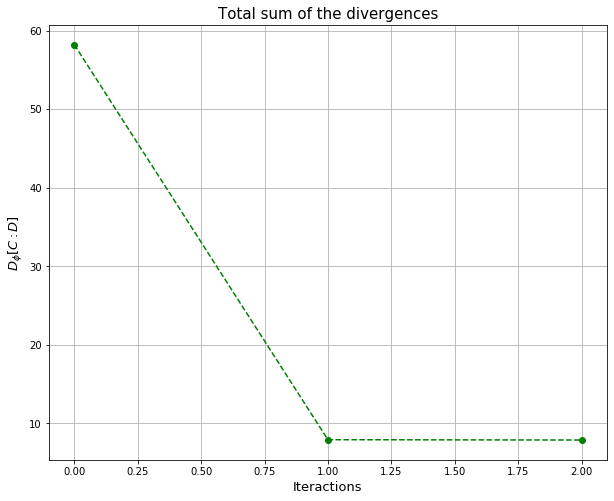

In [8]:
plt.figure(figsize=(10,8))
plt.plot(range(kmeans.get_last_iter()), kmeans.get_sum_total_div(), '--o', c='g')
plt.title('Total sum of the divergences', fontsize=15)
plt.ylabel(r'$D_{\phi}[C: D]$', fontsize=13)
plt.xlabel(r'Iteractions', fontsize=13)
plt.grid()
plt.show()

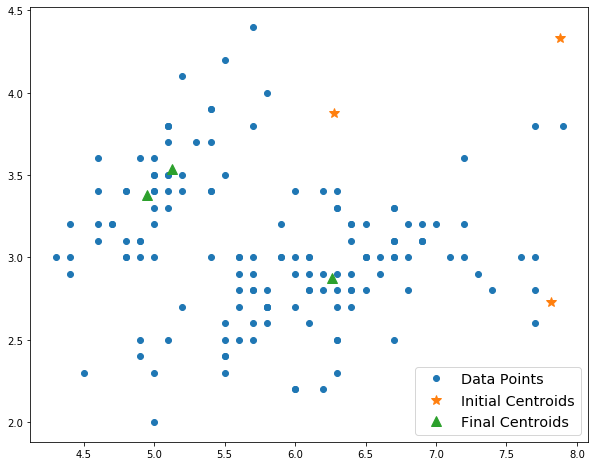

In [9]:
plt.figure(figsize=(10,8))
plt.plot(sample[:,0], sample[:,1], 'o', label='Data Points')
plt.plot(kmeans.get_first_centroids()[:,0], kmeans.get_first_centroids()[:,1], '*',
         markersize=10, label='Initial Centroids')
plt.plot(kmeans.get_centroids()[:,0], kmeans.get_centroids()[:,1], '^',
         markersize=10, label='Final Centroids')
plt.legend(loc='best', fontsize='x-large')
plt.show()

In [10]:
centers = kmeans.get_centroids()

In [11]:
proj_2d = centers[:,:2]

In [12]:
# Get the Voronoi diagrams
vor = Voronoi(proj_2d)

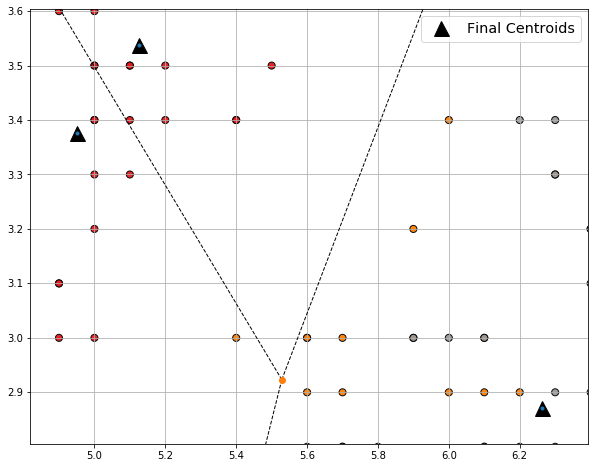

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(10,8))
# Draw data using target to colorize them
axes.scatter(sample[:, 0], sample[:, 1], c=y, cmap='Set1',
             edgecolor='k', s=50, alpha=.95)
# Draw the centroids
axes.plot(centers[:,0], centers[:,1], '^', c='black', markersize=15, label='Final Centroids')
# Draw voronoi
voronoi_plot_2d(vor, ax=axes, show_vertices=True)
plt.grid()
plt.legend(loc='best', fontsize='x-large')
plt.show()